# Import Required Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
import time

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

# 1. Data pre-processing

# Read dataset & change data types

In [2]:
reviews = pd.read_csv('drugsComTrain_raw.tsv',sep='\t',dtype = {'rating' : 'int', 'usefulCount':'int'})
reviews_test = pd.read_csv('drugsComTest_raw.tsv',sep='\t',dtype = {'rating' : 'int', 'usefulCount':'int'})

In [3]:
#Change date type to datetime
reviews["date"] = pd.to_datetime(reviews['date'])
reviews_test["date"] = pd.to_datetime(reviews_test['date'])

In [4]:
reviews.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9 2012-05-20   
1  "My son is halfway through his fourth week of ...       8 2010-04-27   
2  "I used to take another oral contraceptive, wh...       5 2009-12-14   
3  "This is my first time using any form of birth...       8 2015-11-03   
4  "Suboxone has completely turned my life around...       9 2016-11-27   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [5]:
reviews_test.head()

Unnamed: 0         drugName                     condition  \
0      163740      Mirtazapine                    Depression   
1      206473       Mesalamine  Crohn's Disease, Maintenance   
2      159672          Bactrim       Urinary Tract Infection   
3       39293         Contrave                   Weight Loss   
4       97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried a few antidepressants over th...      10 2012-02-28   
1  "My son has Crohn&#039;s disease and has done ...       8 2009-05-17   
2                      "Quick reduction of symptoms"       9 2017-09-29   
3  "Contrave combines drugs that were used for al...       9 2017-03-05   
4  "I have been on this birth control for one cyc...       9 2015-10-22   

   usefulCount  
0           22  
1           17  
2            3  
3           35  
4            4

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
Unnamed: 0     161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null int32
date           161297 non-null datetime64[ns]
usefulCount    161297 non-null int32
dtypes: datetime64[ns](1), int32(2), int64(1), object(3)
memory usage: 7.4+ MB


In [7]:
reviews_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
Unnamed: 0     53766 non-null int64
drugName       53766 non-null object
condition      53471 non-null object
review         53766 non-null object
rating         53766 non-null int32
date           53766 non-null datetime64[ns]
usefulCount    53766 non-null int32
dtypes: datetime64[ns](1), int32(2), int64(1), object(3)
memory usage: 2.5+ MB


# Rename column

In [8]:
#Rename column 1 to ID
reviews.rename(columns={ reviews.columns[0]: "ID" }, inplace = True)
reviews_test.rename(columns={ reviews_test.columns[0]: "ID" }, inplace = True)

# Check column name is changed

In [9]:
reviews.count()

ID             161297
drugName       161297
condition      160398
review         161297
rating         161297
date           161297
usefulCount    161297
dtype: int64

In [10]:
reviews_test.count()

ID             53766
drugName       53766
condition      53471
review         53766
rating         53766
date           53766
usefulCount    53766
dtype: int64

# Check for missing values

In [11]:
reviews.isnull().sum()

ID               0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [12]:
#See records of data with NA values
null_data = reviews[reviews.isnull().any(axis=1)]
null_data.head()

ID                          drugName condition  \
30    51452                      Azithromycin       NaN   
148   61073                              Urea       NaN   
488  132651                           Doxepin       NaN   
733   44297  Ethinyl estradiol / norgestimate       NaN   
851   68697               Medroxyprogesterone       NaN   

                                                review  rating       date  \
30      "Very good response. It is so useful for me. "      10 2010-08-18   
148                            "Accurate information."      10 2011-07-02   
488  "So far so good. Good for me and I can take it...      10 2010-10-20   
733  "I haven&#039;t been on it for a long time and...       8 2011-01-24   
851  "I started the shot in July 2015 and ended in ...       6 2017-03-23   

     usefulCount  
30             1  
148           13  
488           25  
733            1  
851            1

In [13]:
print("Missing value for train data (%):", (reviews['condition'].isnull().sum())/reviews.shape[0] *100)

Missing value for train data (%): 0.5573569254232875


In [14]:
reviews_test.isnull().sum()

ID               0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [15]:
null_data_test = reviews_test[reviews_test.isnull().any(axis=1)]
null_data_test.head()

ID                                    drugName condition  \
34     77164                                  Lorcaserin       NaN   
146   192374            Drospirenone / ethinyl estradiol       NaN   
156   165767                              Levonorgestrel       NaN   
779   157589                                 Guaifenesin       NaN   
1017   96918  Conjugated estrogens / medroxyprogesterone       NaN   

                                                 review  rating       date  \
34    "Have had back and leg pain and sometimes arm ...       5 2014-05-27   
146   "I hate this birth control. I was originally t...       4 2015-04-13   
156   "I&#039;ve never had kids and I am 32 fyi. The...       7 2017-04-03   
779   "You&#039;ll almost always notice a medicinal ...       9 2010-02-23   
1017  "Has not worked one bit still have day and nig...       1 2015-07-06   

      usefulCount  
34             21  
146             8  
156             0  
779            10  
1017            5

In [16]:
print("Missing value for test data (%):", (reviews_test['condition'].isnull().sum())/reviews_test.shape[0] *100)

Missing value for test data (%): 0.5486738831231633


# Eliminate missing values

In [17]:
#Remove rows which has NA values since no. of NA values is < 1%
reviews_filtered = reviews.dropna()
reviews_test_filtered = reviews_test.dropna()

In [18]:
#Double check no NA
reviews_filtered.isnull().sum()

ID             0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [19]:
reviews_test_filtered.isnull().sum()

ID             0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [20]:
reviews_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 7 columns):
ID             160398 non-null int64
drugName       160398 non-null object
condition      160398 non-null object
review         160398 non-null object
rating         160398 non-null int32
date           160398 non-null datetime64[ns]
usefulCount    160398 non-null int32
dtypes: datetime64[ns](1), int32(2), int64(1), object(3)
memory usage: 8.6+ MB


In [21]:
reviews_test_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53471 entries, 0 to 53765
Data columns (total 7 columns):
ID             53471 non-null int64
drugName       53471 non-null object
condition      53471 non-null object
review         53471 non-null object
rating         53471 non-null int32
date           53471 non-null datetime64[ns]
usefulCount    53471 non-null int32
dtypes: datetime64[ns](1), int32(2), int64(1), object(3)
memory usage: 2.9+ MB


# Removed data errors in 'condition' column
In condition column, we found some data errors such as '</span> users found this comment helpful.' and we decided to remove it.

In [22]:
#Check how many records have condition "users found this comment helpful."
reviews_filtered[reviews_filtered['condition'].str.contains("users found this comment helpful")].count()

ID             900
drugName       900
condition      900
review         900
rating         900
date           900
usefulCount    900
dtype: int64

In [23]:
reviews_test_filtered[reviews_test_filtered['condition'].str.contains("users found this comment helpful")].count()

ID             271
drugName       271
condition      271
review         271
rating         271
date           271
usefulCount    271
dtype: int64

In [24]:
reviews_cleaned = reviews_filtered[~reviews_filtered.condition.str.contains("users found this comment helpful")]

In [25]:
reviews_test_cleaned = reviews_test_filtered[~reviews_test_filtered.condition.str.contains("users found this comment helpful")]

# Check ratio of test:train

In [26]:
reviews_test_cleaned["ID"].count()/reviews_cleaned["ID"].count()

0.3335465021504972

Since the test:train ratio is approximately 30:70, we do not need to split the data ourselves and will be just using the train and test data given as it is.

# 2. EDA

# Get reviews count per drug

In [28]:
reviews_cleaned.head()

ID                  drugName                     condition  \
0  206461                 Valsartan  Left Ventricular Dysfunction   
1   95260                Guanfacine                          ADHD   
2   92703                    Lybrel                 Birth Control   
3  138000                Ortho Evra                 Birth Control   
4   35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9 2012-05-20   
1  "My son is halfway through his fourth week of ...       8 2010-04-27   
2  "I used to take another oral contraceptive, wh...       5 2009-12-14   
3  "This is my first time using any form of birth...       8 2015-11-03   
4  "Suboxone has completely turned my life around...       9 2016-11-27   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [29]:
#No. of records of unique drug
pd.set_option("max_rows", None)
reviews_cleaned['drugName'].value_counts().to_frame(name="Count")

Count
Levonorgestrel                                       3631
Etonogestrel                                         3321
Ethinyl estradiol / norethindrone                    2750
Nexplanon                                            2149
Ethinyl estradiol / norgestimate                     2033
Ethinyl estradiol / levonorgestrel                   1809
Phentermine                                          1538
Sertraline                                           1353
Escitalopram                                         1287
Mirena                                               1219
Implanon                                             1095
Gabapentin                                           1042
Bupropion                                            1017
Venlafaxine                                          1012
Miconazole                                            998
Citalopram                                            994
Medroxyprogesterone                                   971
Lexapro                                               947
Bupropion / naltrexone                                945
Duloxetine                                            931
Metronidazole                                         920
Contrave                                              912
Cymbalta                                              860
Drospirenone / ethinyl estradiol                      856
Depo-Provera                                          855
Clonazepam                                            824
Quetiapine                                            823
Skyla                                                 822
Tramadol                                              816
Zoloft                                                799
Varenicline                                           787
Fluoxetine                                            763
Liraglutide                                           752
Tioconazole                                           706
Alprazolam                                            697
Amitriptyline                                         695
Lo Loestrin Fe                                        667
Paroxetine                                            643
Ethinyl estradiol / etonogestrel                      635
Chantix                                               633
Doxycycline                                           627
Magnesium sulfate / potassium sulfate / sodium ...    626
Pregabalin                                            622
NuvaRing                                              620
Copper                                                607
Plan B                                                604
Topiramate                                            603
Suprep Bowel Prep Kit                                 597
Lamotrigine                                           589
Trazodone                                             584
Desvenlafaxine                                        580
Lorcaserin                                            572
Belviq                                                562
Azithromycin                                          546
Pristiq                                               546
Mirtazapine                                           542
Isotretinoin                                          528
Sulfamethoxazole / trimethoprim                       525
Desogestrel / ethinyl estradiol                       511
Vortioxetine                                          506
Nitrofurantoin                                        500
Aripiprazole                                          499
Bisacodyl                                             496
Acetaminophen / hydrocodone                           495
Sprintec                                              492
Celexa                                                491
Diclofenac                                            481
Zolpidem                                              481
Oxycodone                                         

# Get count of reviews by year

In [30]:
#No. of reviews by year
reviews_yearly = reviews_cleaned['date'].groupby([reviews_cleaned.date.dt.year]).count().reset_index(name='reviewsCount')
reviews_yearly

date  reviewsCount
0  2008          5011
1  2009         11464
2  2010          8097
3  2011         11308
4  2012          9717
5  2013         12195
6  2014         11969
7  2015         27027
8  2016         34697
9  2017         28013

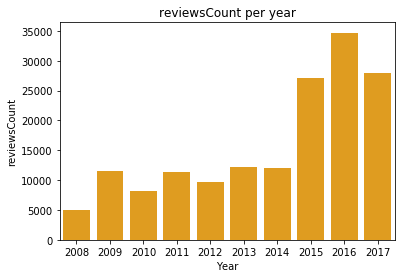

In [31]:
sns.barplot(reviews_yearly["date"], reviews_yearly["reviewsCount"], color ="orange")
plt.xlabel('Year')
plt.ylabel('reviewsCount')
plt.title("reviewsCount per year")
plt.show()

In [32]:
#Top rated drugs by medical condition
reviews_filtered_rating = reviews_cleaned[['date','condition','drugName','rating']]
top_rated = reviews_filtered_rating.groupby(["condition","drugName"]).mean().reset_index()
top_rated.sort_values(["condition","rating"],ascending=False)

condition  \
7813                                        zen Shoulde   
7814                                        zen Shoulde   
7811                                        zen Shoulde   
7812                                        zen Shoulde   
7818                                        zen Shoulde   
7817                                        zen Shoulde   
7815                                        zen Shoulde   
7816                                        zen Shoulde   
7808                           von Willebrand's Disease   
7809                           von Willebrand's Disease   
7810                           von Willebrand's Disease   
7807                                    ungal Pneumonia   
7806                        ungal Infection Prophylaxis   
7805                          unctional Gastric Disorde   
7804                            tic (mycophenolic acid)   
7803       t Pac with Cyclobenzaprine (cyclobenzaprine)   
7801                                             t Care   
7802                                             t Care   
7800                          mulation) (phenylephrine)   
7797                                           moterol)   
7799                                           moterol)   
7798                                           moterol)   
7796                              moterol / mometasone)   
7795                                             mist (   
7794                                                mis   
7791                                               min)   
7790                                               min)   
7792                                               min)   
7793                                               min)   
7789                                               min)   
7788                                 min / sitagliptin)   
7787                                 min / saxagliptin)   
7786                               min / rosiglitazone)   
7785                                min / pioglitazone)   
7784                                                 me   
7783                                      mance Anxiety   
7782                                     m Pain Disorde   
7781                                  llicular Lymphoma   
7779                                lic Acid Deficiency   
7780                                lic Acid Deficiency   
7778                                lic Acid Deficiency   
7736                                        ibromyalgia   
7749                                        ibromyalgia   
7750                                        ibromyalgia   
7766                                        ibromyalgia   
7745                                        ibromyalgia   
7763                                        ibromyalgia   
7752                                        ibromyalgia   
7759                                        ibromyalgia   
7751                                        ibromyalgia   
7762                                        ibromyalgia   
7755                                        ibromyalgia   
7739                                        ibromyalgia   
7735                                        ibromyalgia   
7768                                        ibromyalgia   
7746                                        ibromyalgia   
7758                                        ibromyalgia   
7769                                        ibromyalgia   
7737                                        ibromyalgia   
7760                                        ibromyalgia   
7734                                        ibromyalgia   
7757                                        ibromyalgia   
7772                                        ibromyalgia   
7754                                        ibromyalgia   
7775                                        ibromyalgia   
7740                                        ibromyalgia   
7777                                        ibromyalgia   
7765                              

In [33]:
#Top useful drugs by medical condition
reviews_filtered_useful = reviews_cleaned[['date','condition','drugName','usefulCount']]
top_useful = reviews_filtered_useful.groupby(["condition","drugName"]).sum().reset_index()
top_useful.sort_values(["condition","usefulCount"],ascending=False)

condition  \
7815                                        zen Shoulde   
7811                                        zen Shoulde   
7817                                        zen Shoulde   
7816                                        zen Shoulde   
7818                                        zen Shoulde   
7813                                        zen Shoulde   
7814                                        zen Shoulde   
7812                                        zen Shoulde   
7810                           von Willebrand's Disease   
7808                           von Willebrand's Disease   
7809                           von Willebrand's Disease   
7807                                    ungal Pneumonia   
7806                        ungal Infection Prophylaxis   
7805                          unctional Gastric Disorde   
7804                            tic (mycophenolic acid)   
7803       t Pac with Cyclobenzaprine (cyclobenzaprine)   
7801                                             t Care   
7802                                             t Care   
7800                          mulation) (phenylephrine)   
7798                                           moterol)   
7799                                           moterol)   
7797                                           moterol)   
7796                              moterol / mometasone)   
7795                                             mist (   
7794                                                mis   
7793                                               min)   
7790                                               min)   
7792                                               min)   
7791                                               min)   
7789                                               min)   
7788                                 min / sitagliptin)   
7787                                 min / saxagliptin)   
7786                               min / rosiglitazone)   
7785                                min / pioglitazone)   
7784                                                 me   
7783                                      mance Anxiety   
7782                                     m Pain Disorde   
7781                                  llicular Lymphoma   
7780                                lic Acid Deficiency   
7778                                lic Acid Deficiency   
7779                                lic Acid Deficiency   
7764                                        ibromyalgia   
7753                                        ibromyalgia   
7767                                        ibromyalgia   
7756                                        ibromyalgia   
7748                                        ibromyalgia   
7741                                        ibromyalgia   
7738                                        ibromyalgia   
7772                                        ibromyalgia   
7751                                        ibromyalgia   
7733                                        ibromyalgia   
7758                                        ibromyalgia   
7754                                        ibromyalgia   
7737                                        ibromyalgia   
7774                                        ibromyalgia   
7771                                        ibromyalgia   
7761                                        ibromyalgia   
7776                                        ibromyalgia   
7744                                        ibromyalgia   
7760                                        ibromyalgia   
7763                                        ibromyalgia   
7770                                        ibromyalgia   
7755                                        ibromyalgia   
7768                                        ibromyalgia   
7746                                        ibromyalgia   
7773                                        ibromyalgia   
7757                                        ibromyalgia   
7762                              

# Top 10 Medical Conditions by ReviewsCount

In [34]:
top10_conditions = reviews_cleaned.condition.value_counts().sort_values(ascending=False)
top10_conditions[:10]

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

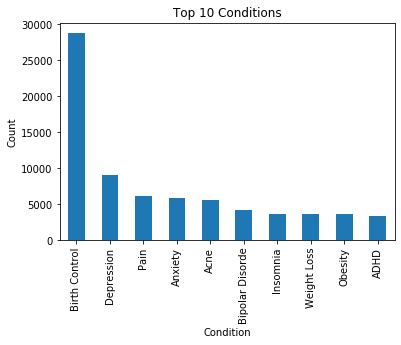

In [35]:
top10_conditions[:10].plot(kind='bar')
plt.title('Top 10 Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

# Drugs count per Top 10 medical condition

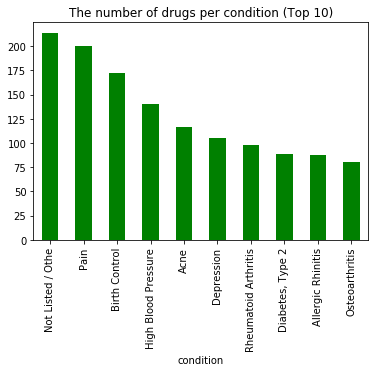

In [36]:
numDrugs_condition = reviews_cleaned.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
numDrugs_condition[0:10].plot(kind="bar", color="green")
plt.title("The number of drugs per condition (Top 10)")
plt.show()

# Correlation of numerical columns

usefulCount and Rating have a low positive correlation

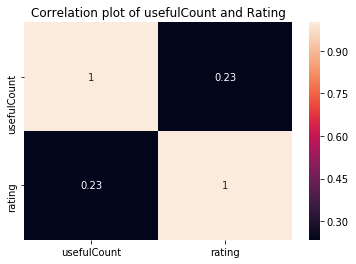

In [37]:
#Overall correlation of usefulCount and rating
sns.heatmap(reviews_cleaned[["usefulCount","rating"]].corr(), annot=True)
plt.title("Correlation plot of usefulCount and Rating")
plt.show()

# Count of records per 'rating' value

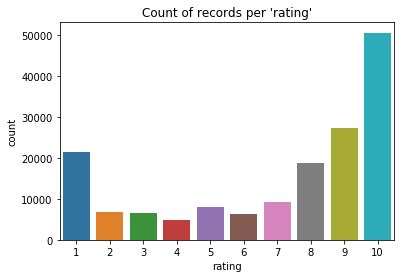

In [38]:
sns.countplot(reviews_cleaned['rating'])
plt.title("Count of records per 'rating'")
plt.show()

# 'rating' Distribution

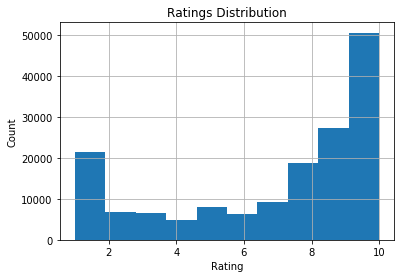

In [39]:
reviews_cleaned.rating.hist()
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 'usefulCount' Boxplot, Distribution & Statistics

Outliers are present usefulCount

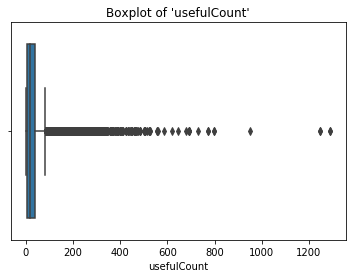

In [40]:
sns.boxplot(reviews_cleaned['usefulCount'])
plt.title("Boxplot of 'usefulCount'")
plt.show()

usefulCount is highly skewed

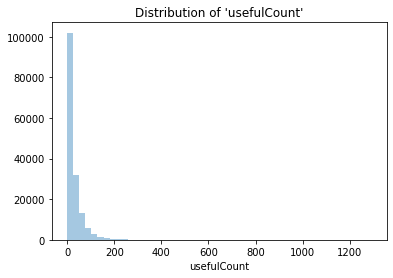

In [41]:
sns.distplot(reviews_cleaned['usefulCount'], kde=False)
plt.title("Distribution of 'usefulCount'")
plt.show()

In [42]:
reviews_cleaned['usefulCount'].describe()

count    159498.000000
mean         28.192335
std          36.512639
min           0.000000
25%           6.000000
50%          16.000000
75%          37.000000
max        1291.000000
Name: usefulCount, dtype: float64

# Sentiment Analysis (Wordcloud and Sentiment Scores)

In [43]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


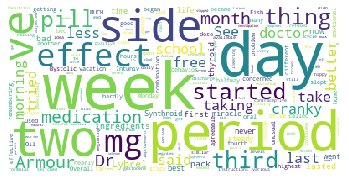

In [44]:
#remove certain stop words
stop_words = set(stopwords.words('english'))

notremove_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in notremove_stop:
    stop_words.remove(i)

reviews_cleaned['review'] = reviews_cleaned['review'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

text = reviews_cleaned['review'].values 
wordcloud = WordCloud(background_color='white').generate(str(text))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


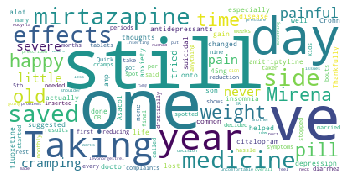

In [45]:
#Do the same for test data
stop_words = set(stopwords.words('english'))

notremove_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in notremove_stop:
    stop_words.remove(i)

reviews_test_cleaned['review'] = reviews_test_cleaned['review'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

text_test = reviews_test_cleaned['review'].values 
wordcloud_test = WordCloud(background_color='white').generate(str(text_test))

plt.imshow(wordcloud_test)
plt.axis('off')
plt.show()

# Vader

In [46]:
sentiment_analyser = SentimentIntensityAnalyzer()

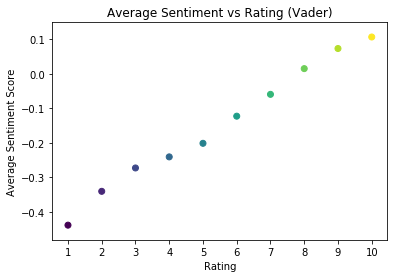

In [48]:
sentiments_vader = []

for i in reviews_cleaned.review:
    sentiments_vader.append(sentiment_analyser.polarity_scores(i).get('compound'))
    
sentiments_vader = np.asarray(sentiments_vader)

reviews_cleaned['sentiment_vader'] = pd.Series(data=sentiments_vader)
reviews_cleaned = reviews_cleaned.reset_index(drop=True)

avg_score_per_rating_vader = []

for i in range(1, 11):
    sum_of_score_vader = np.sum(reviews_cleaned[reviews_cleaned.rating == i].sentiment_vader)
    no_of_rows_vader = np.sum(reviews_cleaned.rating == i)
    average_vader = sum_of_score_vader/no_of_rows_vader
    avg_score_per_rating_vader.append(average_vader)


plt.scatter(x=range(1, 11), y=avg_score_per_rating_vader, c=range(1, 11))
plt.title('Average Sentiment vs Rating (Vader)')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.xticks([i for i in range(1, 11)]);

` Score >= 0.05 : Positive 
-0.05 < Score < 0.05 : Neutral
Score <= -0.05 : Negative `

From the plot above, we can see that rating 7 and 8 has neutral sentiment, rating 9 and 10 has positive sentiment and rating < 7 has negative sentiment. From our research, VADER seems to work better with things like slang, emojis, etc — whereas TextBlob performs better with more formal language usage. Since our reviews are written in more formal language, we decided to go with textBlob.

Hence, we feel that Vader is not performing well for this dataset. We decided to try an alternative Sentiment Analysis library, TextBlob.

# TextBlob

In [49]:
from textblob import TextBlob

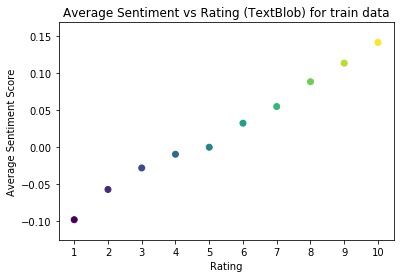

In [51]:
# polarity >= 0, positive
# polarity < 0, negative

sentiments_textblob = []

for review in reviews_cleaned.review:
    review = TextBlob(review)
    sentiments_textblob.append(review.sentiment.polarity)

sentiments_textblob = np.asarray(sentiments_textblob)   

reviews_cleaned['sentiment_textblob'] = pd.Series(data=sentiments_textblob)
reviews_cleaned= reviews_cleaned.reset_index(drop=True)

avg_score_per_rating_textblob = []

for i in range(1, 11):
    sum_of_score = np.sum(reviews_cleaned[reviews_cleaned.rating == i].sentiment_textblob)
    no_of_rows = np.sum(reviews_cleaned.rating == i)
    average = sum_of_score/no_of_rows
    avg_score_per_rating_textblob.append(average)


plt.scatter(x=range(1, 11), y=avg_score_per_rating_textblob, c=range(1, 11))
plt.title('Average Sentiment vs Rating (TextBlob) for train data')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.xticks([i for i in range(1, 11)]);

`score >= 0, positive
score < 0, negative`

From the plot above, we can see that rating and average sentiment score has a positive relationship. Higher rated drugs have more positive sentiment.

We believe that TextBlob is performing better than Vader for this dataset. Hence, we will proceed with analysis using TextBlob sentiment scores.

In [52]:
#remove vader column from reviews_cleaned
reviews_cleaned.drop(columns=['sentiment_vader'], inplace = True)
reviews_cleaned.head()

ID                  drugName                     condition  \
0  206461                 Valsartan  Left Ventricular Dysfunction   
1   95260                Guanfacine                          ADHD   
2   92703                    Lybrel                 Birth Control   
3  138000                Ortho Evra                 Birth Control   
4   35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It no side effect, I take combination Bystoli...       9 2012-05-20   
1  "My son halfway fourth week Intuniv. We became...       8 2010-04-27   
2  "I used take another oral contraceptive, 21 pi...       5 2009-12-14   
3  "This first time using form birth control. I&#...       8 2015-11-03   
4  "Suboxone completely turned life around. I fee...       9 2016-11-27   

   usefulCount  sentiment_textblob  
0           27            0.000000  
1          192            0.151944  
2           17            0.076948  
3           10            0.219444  
4           37            0.194444

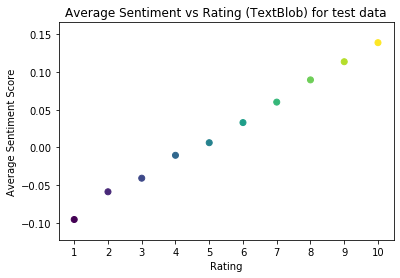

In [54]:
#Repeat for test data
sentiment_textblob_test = []

for review in reviews_test_cleaned.review:
    review = TextBlob(review)
    sentiment_textblob_test.append(review.sentiment.polarity)

sentiment_textblob_test = np.asarray(sentiment_textblob_test)   

reviews_test_cleaned['sentiment_textblob_test'] = pd.Series(data=sentiment_textblob_test)
reviews_test_cleaned= reviews_test_cleaned.reset_index(drop=True)

avg_score_per_rating_textblob_test = []

for i in range(1, 11):
    sum_of_score_test = np.sum(reviews_test_cleaned[reviews_test_cleaned.rating == i].sentiment_textblob_test)
    no_of_rows_test = np.sum(reviews_test_cleaned.rating == i)
    average_test = sum_of_score_test/no_of_rows_test
    avg_score_per_rating_textblob_test.append(average_test)

plt.scatter(x=range(1, 11), y=avg_score_per_rating_textblob_test, c=range(1, 11))
plt.title('Average Sentiment vs Rating (TextBlob) for test data')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.xticks([i for i in range(1, 11)]);

In [55]:
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  
0           22                -0.300000  
1           17                 0.650000  
2            3                 0.333333  
3           35                 0.253125  
4            4                 0.269951

# 1. Sentiment Classifiers

We will be using vectorization to convert the raw text of the review into a numerical format which then can be processed by  classifiers.

This can be acheived using the TI-IDF method. TI-IDF evaluates how relevant a word is to a document in a collection of documents by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

Referenced from: https://www.kaggle.com/burhanykiyakoglu/predicting-sentiment-from-clothing-reviews

In [56]:
vectorizer = TfidfVectorizer()

In [57]:
# Rating of 6 or higher -> positive
# Rating of 4 or lower -> negative 
# Rating of 5 -> neutral (removed as it is a binary classification, positive or negative only)
df_train = reviews_cleaned[reviews_cleaned['rating'] != 5]
df_train['Sentiment'] = df_train['rating'] >=6

df_test = reviews_test_cleaned[reviews_test_cleaned['rating'] != 5]
df_test['Sentiment'] = df_test['rating'] >=6

# select the columns and 
# prepare data for the models 
# fit and transform data
X_train = vectorizer.fit_transform(df_train['review'])
y_train = df_train['Sentiment']
X_test = vectorizer.transform(df_test['review'])
y_test = df_test['Sentiment']

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Check ratio of test:train

In [58]:
df_test["ID"].count()/df_train["ID"].count()

0.33331794103871604

Now, we will put the data into machine learning models to classify the sentiments.

1. Logistic Regression

In [59]:
#Logistic Regression
import datetime as dt
start=dt.datetime.now()
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:19.339899


2. Naive Bayes

In [60]:
#NB
start=dt.datetime.now()
nb = MultinomialNB()
nb.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.112626


3. Decision Tree Classifier

In [61]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
start=dt.datetime.now()
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:10:42.220888


4. Random Forest

In [62]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
start=dt.datetime.now()
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:15:53.294418


5. Ada Boost Classifier

In [63]:
#Ada Boost Classifier
from sklearn.ensemble import AdaBoostClassifier
start=dt.datetime.now()
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:01:00.919036


6. K-nearest neighbors

In [64]:
#K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
start=dt.datetime.now()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.080998


Confusion Matrix

In [65]:
from sklearn.metrics import confusion_matrix

lr_cm=confusion_matrix(y_test.values, lr.predict(X_test))
nb_cm=confusion_matrix(y_test.values, nb.predict(X_test))
dtree_cm=confusion_matrix(y_test.values, dtree.predict(X_test))
clf_cm=confusion_matrix(y_test.values, clf.predict(X_test))
knn_cm=confusion_matrix(y_test.values, knn.predict(X_test))
abc_cm=confusion_matrix(y_test.values, abc.predict(X_test))

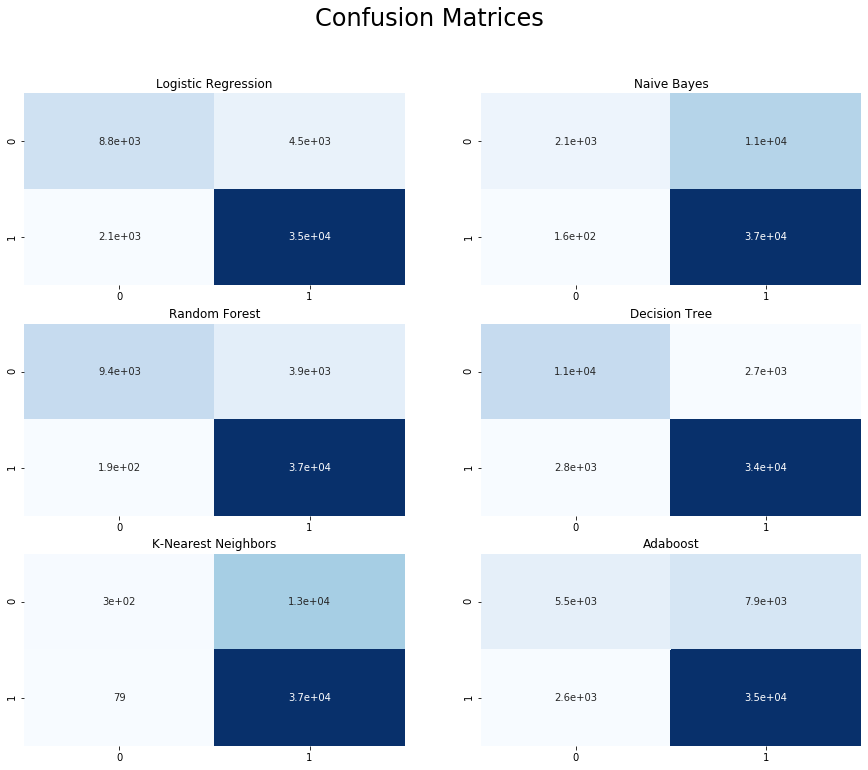

In [66]:
plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(3,2,1)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, annot = True, cmap="Blues",cbar=False);

plt.subplot(3,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot = True, cmap="Blues",cbar=False);

plt.subplot(3,2,3)
plt.title("Random Forest")
sns.heatmap(clf_cm, annot = True, cmap="Blues",cbar=False);

plt.subplot(3,2,4)
plt.title("Decision Tree")
sns.heatmap(dtree_cm, annot = True, cmap="Blues",cbar=False);

plt.subplot(3,2,5)
plt.title("K-Nearest Neighbors")
sns.heatmap(knn_cm, annot = True, cmap="Blues",cbar=False);

plt.subplot(3,2,6)
plt.title("Adaboost")
sns.heatmap(abc_cm, annot = True, cmap="Blues",cbar=False);

In [67]:
import sklearn.metrics as mt
from sklearn.metrics import accuracy_score

print("Logistic Regression \n")
print("Accuracy:", accuracy_score(y_test, lr.predict(X_test)), "\n")
print(mt.classification_report(y_test, lr.predict(X_test)), "\n")

print("Naive Bayes \n")
print("Accuracy:", accuracy_score(y_test, nb.predict(X_test)), "\n")
print(mt.classification_report(y_test, nb.predict(X_test)), "\n")

print("Random Forest \n")
print("Accuracy:", accuracy_score(y_test, clf.predict(X_test)), "\n")
print(mt.classification_report(y_test, clf.predict(X_test)), "\n")

print("Decision Tree \n")
print("Accuracy:", accuracy_score(y_test, dtree.predict(X_test)), "\n")
print(mt.classification_report(y_test, dtree.predict(X_test)), "\n")

print("K-Nearest Neighbors \n")
print("Accuracy:", accuracy_score(y_test, knn.predict(X_test)), "\n")
print(mt.classification_report(y_test, knn.predict(X_test)), "\n")

print("Adaboost \n")
print("Accuracy:", accuracy_score(y_test, abc.predict(X_test)), "\n")
print(mt.classification_report(y_test, abc.predict(X_test)), "\n")

Logistic Regression 

Accuracy: 0.8688845788473718 

              precision    recall  f1-score   support

       False       0.81      0.66      0.73     13355
        True       0.89      0.94      0.91     37173

    accuracy                           0.87     50528
   macro avg       0.85      0.80      0.82     50528
weighted avg       0.87      0.87      0.86     50528
 

Naive Bayes 

Accuracy: 0.7738283723875871 

              precision    recall  f1-score   support

       False       0.93      0.16      0.27     13355
        True       0.77      1.00      0.87     37173

    accuracy                           0.77     50528
   macro avg       0.85      0.58      0.57     50528
weighted avg       0.81      0.77      0.71     50528
 

Random Forest 

Accuracy: 0.9185797973400887 

              precision    recall  f1-score   support

       False       0.98      0.71      0.82     13355
        True       0.90      0.99      0.95     37173

    accuracy                     

Since the data is imbalance (13355 vs 37173), we cannot use accuracy to determine which model performed the best. Instead, we should use the macro avg of F1 score. 

Random Forest has the highest macro avg for F1 score, 88%. Hence, Random Forest is the best performing model out of the 6 sentiment classifier models.

# 2. Predict Drug Rating

Scale the data using RobustScalar since we have outliers in our dataset

In [68]:
#Make a new df that is used for scaling
from sklearn import preprocessing

r_scaler = preprocessing.RobustScaler()

cols = reviews_cleaned[['usefulCount','sentiment_textblob','rating']]
cols_test = reviews_test_cleaned[['usefulCount','sentiment_textblob_test','rating']]

df_r = r_scaler.fit_transform(cols)
df_r_test = r_scaler.fit_transform(cols_test)

df_r = pd.DataFrame(df_r, columns=['usefulCount_scaled','sentiment_textblob_scaled','rating_scaled'])
df_r_test = pd.DataFrame(df_r_test, columns=['usefulCount_scaled','sentiment_textblob_test_scaled','rating_scaled'])

reviews_cleaned['usefulCount_scaled'] = df_r['usefulCount_scaled']
reviews_cleaned['sentiment_textblob_scaled'] = df_r['sentiment_textblob_scaled']
reviews_cleaned['rating_scaled'] = df_r['rating_scaled']

reviews_test_cleaned['usefulCount_scaled'] = df_r_test['usefulCount_scaled']
reviews_test_cleaned['sentiment_textblob_test_scaled'] = df_r_test['sentiment_textblob_test_scaled']
reviews_test_cleaned['rating_scaled'] = df_r_test['rating_scaled']

In [69]:
#train data
reviews_cleaned.head()

ID                  drugName                     condition  \
0  206461                 Valsartan  Left Ventricular Dysfunction   
1   95260                Guanfacine                          ADHD   
2   92703                    Lybrel                 Birth Control   
3  138000                Ortho Evra                 Birth Control   
4   35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It no side effect, I take combination Bystoli...       9 2012-05-20   
1  "My son halfway fourth week Intuniv. We became...       8 2010-04-27   
2  "I used take another oral contraceptive, 21 pi...       5 2009-12-14   
3  "This first time using form birth control. I&#...       8 2015-11-03   
4  "Suboxone completely turned life around. I fee...       9 2016-11-27   

   usefulCount  sentiment_textblob  usefulCount_scaled  \
0           27            0.000000            0.354839   
1          192            0.151944            5.677419   
2           17            0.076948            0.032258   
3           10            0.219444           -0.193548   
4           37            0.194444            0.677419   

   sentiment_textblob_scaled  rating_scaled  
0                  -0.223283            0.2  
1                   0.422938            0.0  
2                   0.103978           -0.6  
3                   0.710017            0.0  
4                   0.603691            0.2

In [70]:
#test data
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  
0                       -1.490737       0.333333  
1                        2.545937       0.000000  
2                        1.200379       0.166667  
3                        0.859564       0.166667  
4                        0.931059       0.166667

Now we will put our scaled data to train our regression models. Thereafter, the models will predict the drug rating of the test data.

1. KNN  (scaled)

Referenced from: https://www.dataquest.io/blog/machine-learning-tutorial/

In [71]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
train_features = reviews_cleaned[['usefulCount_scaled','sentiment_textblob_scaled']]
train_target = reviews_cleaned[['rating_scaled']]

model_knn = knn.fit(train_features, train_target)

test_features =  reviews_test_cleaned[['usefulCount_scaled','sentiment_textblob_test_scaled']]

predictions = knn.predict(test_features)

In [72]:
print(predictions)

[[-1.12]
 [-0.12]
 [ 0.16]
 ...
 [-0.68]
 [-0.72]
 [ 0.12]]


In [73]:
reviews_test_cleaned['predicted_rating_knn'] = predictions[:,0]
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  predicted_rating_knn  
0                       -1.490737       0.333333                 -1.12  
1                        2.545937       0.000000                 -0.12  
2                        1.200379       0.166667                  0.16  
3                        0.859564       0.166667                  0.24  
4                        0.931059       0.166667                 -0.56

In [74]:
from sklearn.metrics import mean_squared_error

mse_knn = mean_squared_error(reviews_test_cleaned['rating_scaled'], predictions)
rmse_knn = mse_knn ** (1/2)

print("RMSE:",rmse_knn)

RMSE: 0.5734837441858722


We wanted to see if there are any difference in the performance of the model if we did not scale our X variables (usefulCount and sentiment_textblob). Hence, we put our unscaled train data into the KNN regressor to train the model and then used the model to predict the ratings of the drug.

KNN (unscaled)

In [75]:
train_features = reviews_cleaned[['usefulCount','sentiment_textblob']]
train_target = reviews_cleaned[['rating']]

knn.fit(train_features, train_target)

test_features =  reviews_test_cleaned[['usefulCount','sentiment_textblob_test']]

predictions_unscaled = knn.predict(test_features)

print(predictions_unscaled)

[[4.2]
 [7.2]
 [8.2]
 ...
 [7.6]
 [7.8]
 [6.8]]


In [76]:
reviews_test_cleaned['predicted_rating_knn_unscaled'] = predictions[:,0]
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  predicted_rating_knn  \
0                       -1.490737       0.333333                 -1.12   
1                        2.545937       0.000000                 -0.12   
2                        1.200379       0.166667                  0.16   
3                        0.859564       0.166667                  0.24   
4                        0.931059       0.166667                 -0.56   

   predicted_rating_knn_unscaled  
0                          -1.12  
1                          -0.12  
2                           0.16  
3                           0.24  
4                          -0.56

In [77]:
mse_knn_unscaled = mean_squared_error(reviews_test_cleaned['rating'], predictions_unscaled)
rmse_knn_unscaled = mse_knn_unscaled ** (1/2)

print("RMSE:",rmse_knn_unscaled)

RMSE: 3.0293172758717


Comparing the RMSE of KNN of using scaled and unscaled features, we can see that by scaling our data, the RMSE is so much better. Hence, we will use our scaled data to perform other regression models for predicting drug rating.

2. MLR

Referenced from: https://heartbeat.fritz.ai/implementing-multiple-linear-regression-using-sklearn-43b3d3f2fe8b

In [78]:
from sklearn.linear_model import LinearRegression

X = reviews_cleaned[['usefulCount_scaled','sentiment_textblob_scaled']]
y = reviews_cleaned['rating_scaled']

model = LinearRegression().fit(X, y)

r_sq = model.score(X, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.16767428925748373
intercept: -0.25291572773356524
slope: [0.11131624 0.21768091]


In [79]:
X_test = reviews_test_cleaned[['usefulCount_scaled','sentiment_textblob_test_scaled']]
y_pred = model.predict(X_test)

In [80]:
predictions_mlr = y_pred.reshape(-1, 1)
print(predictions_mlr)

[[-0.55515739]
 [ 0.30499678]
 [-0.03985309]
 ...
 [-0.39809597]
 [-0.28509209]
 [-0.18861801]]


In [81]:
reviews_test_cleaned['predicted_rating_mlr'] = predictions_mlr[:,0]
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  predicted_rating_knn  \
0                       -1.490737       0.333333                 -1.12   
1                        2.545937       0.000000                 -0.12   
2                        1.200379       0.166667                  0.16   
3                        0.859564       0.166667                  0.24   
4                        0.931059       0.166667                 -0.56   

   predicted_rating_knn_unscaled  predicted_rating_mlr  
0                          -1.12             -0.555157  
1                          -0.12              0.304997  
2                           0.16             -0.039853  
3                           0.24              0.004695  
4                          -0.56             -0.094768

In [82]:
mse_mlr = mean_squared_error(reviews_test_cleaned['rating_scaled'], predictions_mlr)
rmse_mlr = mse_mlr ** (1/2)

print("RMSE:", rmse_mlr)

RMSE: 0.5022879110257089


3. Decision Tree Regression

In [83]:
from sklearn.tree import DecisionTreeRegressor

X = reviews_cleaned[['usefulCount_scaled','sentiment_textblob_scaled']]
y = reviews_cleaned['rating_scaled']

regressor = DecisionTreeRegressor(random_state = 0)

regressor.fit(X, y)

DecisionTreeRegressor(random_state=0)

In [84]:
X_test = reviews_test_cleaned[['usefulCount_scaled','sentiment_textblob_test_scaled']]
y_pred = regressor.predict(X_test)

In [85]:
predictions_dt = y_pred.reshape(-1, 1)
print(predictions_dt)

[[-1.        ]
 [-0.05      ]
 [-1.2       ]
 ...
 [-1.        ]
 [-1.33333333]
 [ 0.2       ]]


In [86]:
reviews_test_cleaned['predicted_rating_dt'] = predictions_dt[:,0]
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  predicted_rating_knn  \
0                       -1.490737       0.333333                 -1.12   
1                        2.545937       0.000000                 -0.12   
2                        1.200379       0.166667                  0.16   
3                        0.859564       0.166667                  0.24   
4                        0.931059       0.166667                 -0.56   

   predicted_rating_knn_unscaled  predicted_rating_mlr  predicted_rating_dt  
0                          -1.12             -0.555157            -1.000000  
1                          -0.12              0.304997            -0.050000  
2                           0.16             -0.039853            -1.200000  
3                           0.24              0.004695             0.400000  
4                          -0.56             -0.094768            -0.866667

In [87]:
mse_dt = mean_squared_error(reviews_test_cleaned['rating_scaled'], predictions_dt)
rmse_dt = mse_dt ** (1/2)

print("RMSE:", rmse_dt)

RMSE: 0.7251606278176802


4.  LASSO Regression

In [88]:
from sklearn.linear_model import LassoCV

X_train = reviews_cleaned[['usefulCount_scaled','sentiment_textblob_scaled']]
y_train = reviews_cleaned[['rating_scaled']]

lasso = LassoCV()
lasso.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [89]:
X_test =  reviews_test_cleaned[['usefulCount_scaled','sentiment_textblob_test_scaled']]
predictions_lasso = lasso.predict(X_test)

In [90]:
predictions_lasso = predictions_lasso.reshape(-1, 1)
print(predictions_lasso)

[[-0.55480227]
 [ 0.30451825]
 [-0.03997408]
 ...
 [-0.39787255]
 [-0.28499809]
 [-0.18865622]]


In [91]:
reviews_test_cleaned['predicted_rating_lasso'] = predictions_lasso[:,0]
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  predicted_rating_knn  \
0                       -1.490737       0.333333                 -1.12   
1                        2.545937       0.000000                 -0.12   
2                        1.200379       0.166667                  0.16   
3                        0.859564       0.166667                  0.24   
4                        0.931059       0.166667                 -0.56   

   predicted_rating_knn_unscaled  predicted_rating_mlr  predicted_rating_dt  \
0                          -1.12             -0.555157            -1.000000   
1                          -0.12              0.304997            -0.050000   
2                           0.16             -0.039853            -1.200000   
3                           0.24              0.004695             0.400000   
4                          -0.56             -0.094768            -0.866667   

   predicted_rating_lasso  
0               -0.554802  
1                0.304518  
2               -0.039974  
3                0.004484  
4               -0.094837

In [92]:
mse_lasso = mean_squared_error(reviews_test_cleaned['rating_scaled'], predictions_lasso)
rmse_lasso = mse_lasso ** (1/2)

print("RMSE:", rmse_lasso)

RMSE: 0.5022619755414564


5. Ridge

In [93]:
from sklearn.linear_model import Ridge

X_train = reviews_cleaned[['usefulCount_scaled','sentiment_textblob_scaled']]
y_train = reviews_cleaned[['rating_scaled']]

ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [94]:
X_test =  reviews_test_cleaned[['usefulCount_scaled','sentiment_textblob_test_scaled']]
predictions_ridge = ridge.predict(X_test)

In [95]:
predictions_ridge = predictions_ridge.reshape(-1, 1)
print(predictions_ridge)

[[-0.55515535]
 [ 0.30499371]
 [-0.03985425]
 ...
 [-0.39809499]
 [-0.28509166]
 [-0.18861792]]


In [96]:
reviews_test_cleaned['predicted_rating_ridge'] = predictions_ridge[:,0]
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  predicted_rating_knn  \
0                       -1.490737       0.333333                 -1.12   
1                        2.545937       0.000000                 -0.12   
2                        1.200379       0.166667                  0.16   
3                        0.859564       0.166667                  0.24   
4                        0.931059       0.166667                 -0.56   

   predicted_rating_knn_unscaled  predicted_rating_mlr  predicted_rating_dt  \
0                          -1.12             -0.555157            -1.000000   
1                          -0.12              0.304997            -0.050000   
2                           0.16             -0.039853            -1.200000   
3                           0.24              0.004695             0.400000   
4                          -0.56             -0.094768            -0.866667   

   predicted_rating_lasso  predicted_rating_ridge  
0               -0.554802               -0.555155  
1                0.304518                0.304994  
2               -0.039974               -0.039854  
3                0.004484                0.004694  
4               -0.094837               -0.094769

In [97]:
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(reviews_test_cleaned['rating_scaled'], predictions_ridge)
rmse_ridge = mse_ridge ** (1/2)
print("RMSE:",rmse_ridge)

RMSE: 0.5022877882160374


6. ElasticNet Regression

In [98]:
from sklearn.linear_model import ElasticNet

X_train = reviews_cleaned[['usefulCount_scaled','sentiment_textblob_scaled']]
y_train = reviews_cleaned[['rating_scaled']]

elasticnet = ElasticNet()
elasticnet.fit(X_train, y_train)

ElasticNet()

In [99]:
X_test =  reviews_test_cleaned[['usefulCount_scaled','sentiment_textblob_test_scaled']]
predictions_elasticnet = elasticnet.predict(X_test)

In [100]:
predictions_elasticnet = predictions_elasticnet.reshape(-1, 1)
print(predictions_elasticnet)

[[-0.20057054]
 [-0.20057054]
 [-0.20057054]
 ...
 [-0.20057054]
 [-0.20057054]
 [-0.20057054]]


In [101]:
reviews_test_cleaned['predicted_rating_elasticnet'] = predictions_elasticnet[:,0]
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  predicted_rating_knn  \
0                       -1.490737       0.333333                 -1.12   
1                        2.545937       0.000000                 -0.12   
2                        1.200379       0.166667                  0.16   
3                        0.859564       0.166667                  0.24   
4                        0.931059       0.166667                 -0.56   

   predicted_rating_knn_unscaled  predicted_rating_mlr  predicted_rating_dt  \
0                          -1.12             -0.555157            -1.000000   
1                          -0.12              0.304997            -0.050000   
2                           0.16             -0.039853            -1.200000   
3                           0.24              0.004695             0.400000   
4                          -0.56             -0.094768            -0.866667   

   predicted_rating_lasso  predicted_rating_ridge  predicted_rating_elasticnet  
0               -0.554802               -0.555155                    -0.200571  
1                0.304518                0.304994                    -0.200571  
2               -0.039974               -0.039854                    -0.200571  
3                0.004484                0.004694                    -0.200571  
4               -0.094837               -0.094769                    -0.200571

In [102]:
from sklearn.metrics import mean_squared_error
mse_elasticnet = mean_squared_error(reviews_test_cleaned['rating_scaled'], predictions_elasticnet)
rmse_elasticnet = mse_elasticnet ** (1/2)
print("RMSE:",rmse_elasticnet)

RMSE: 0.5485629829195381


Comparing the RMSE of all 6 models

In [103]:
#Overall rmse
print("Comparison of rmse for the 6 models")
print("KNN:",rmse_knn)
print("MLR:",rmse_mlr)
print("Decision Tree:",rmse_dt)
print("LASSO:",rmse_lasso)
print("Ridge:",rmse_ridge)
print("ElasticNet:",rmse_elasticnet)

Comparison of rmse for the 6 models
KNN: 0.5734837441858722
MLR: 0.5022879110257089
Decision Tree: 0.7251606278176802
LASSO: 0.5022619755414564
Ridge: 0.5022877882160374
ElasticNet: 0.5485629829195381


RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction. Hence, we used RMSE to determine which model performed the best.

LASSO is the best performing model as it has the smallest RMSE. Lower values of RMSE indicate better fit. 

# 3. Determine Overall Score for Drugs

The equation we came out with for determining the overall score of drugs is:

 `score = x%(Median usefulCount) + y%(Number of users who rated the drug) + z%(Median rating of drug) `
 
 `x, y, z will be determined using feature importance`
   
 We ommitted the median sentiment score for each review because the sentiment score is correlated with rating.

In [104]:
reviews_test_cleaned.head()

ID         drugName                     condition  \
0  163740      Mirtazapine                    Depression   
1  206473       Mesalamine  Crohn's Disease, Maintenance   
2  159672          Bactrim       Urinary Tract Infection   
3   39293         Contrave                   Weight Loss   
4   97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried antidepressants years (citalo...      10 2012-02-28   
1  "My son Crohn&#039;s disease done well Asacol....       8 2009-05-17   
2                         "Quick reduction symptoms"       9 2017-09-29   
3  "Contrave combines drugs used alcohol, smoking...       9 2017-03-05   
4  "I birth control one cycle. After reading revi...       9 2015-10-22   

   usefulCount  sentiment_textblob_test  usefulCount_scaled  \
0           22                -0.300000            0.200000   
1           17                 0.650000            0.033333   
2            3                 0.333333           -0.433333   
3           35                 0.253125            0.633333   
4            4                 0.269951           -0.400000   

   sentiment_textblob_test_scaled  rating_scaled  predicted_rating_knn  \
0                       -1.490737       0.333333                 -1.12   
1                        2.545937       0.000000                 -0.12   
2                        1.200379       0.166667                  0.16   
3                        0.859564       0.166667                  0.24   
4                        0.931059       0.166667                 -0.56   

   predicted_rating_knn_unscaled  predicted_rating_mlr  predicted_rating_dt  \
0                          -1.12             -0.555157            -1.000000   
1                          -0.12              0.304997            -0.050000   
2                           0.16             -0.039853            -1.200000   
3                           0.24              0.004695             0.400000   
4                          -0.56             -0.094768            -0.866667   

   predicted_rating_lasso  predicted_rating_ridge  predicted_rating_elasticnet  
0               -0.554802               -0.555155                    -0.200571  
1                0.304518                0.304994                    -0.200571  
2               -0.039974               -0.039854                    -0.200571  
3                0.004484                0.004694                    -0.200571  
4               -0.094837               -0.094769                    -0.200571

In [105]:
#getting the number of users who rated the drugs for each drug
grouped_by = reviews_test_cleaned.groupby(by=["drugName","condition"]).count()
n_users = grouped_by["ID"].to_frame().reset_index()
n_users = n_users.rename(columns={'drugName':'drugName','ID':'Number of users'})
n_users.head()

drugName             condition  Number of users
0                            A / B Otic          Otitis Media                1
1  Abacavir / dolutegravir / lamivudine         HIV Infection               18
2                 Abacavir / lamivudine         HIV Infection                3
3                             Abatacept  Rheumatoid Arthritis                6
4                               Abilify        Agitated State                1

In [106]:
#getting the median rating of drug for each drug, used median instead of mean due to outliers
grouped_by_rating = reviews_test_cleaned.groupby(by=["drugName","condition"])['rating'].median()
med_rating = grouped_by_rating.to_frame().reset_index()
med_rating = med_rating.rename(columns={'drugName':'drugName','rating':'Median rating'})
med_rating.head()

drugName             condition  Median rating
0                            A / B Otic          Otitis Media           10.0
1  Abacavir / dolutegravir / lamivudine         HIV Infection           10.0
2                 Abacavir / lamivudine         HIV Infection           10.0
3                             Abatacept  Rheumatoid Arthritis            7.0
4                               Abilify        Agitated State           10.0

In [107]:
#getting the median usefulCount of drug for each drug, used median instead of mean due to outliers
grouped_by_useful = reviews_test_cleaned.groupby(by=["drugName","condition"])['usefulCount'].median()
med_useful = grouped_by_useful.to_frame().reset_index()
med_useful = med_useful.rename(columns={'drugName':'drugName','usefulCount':'Median usefulCount'})
med_useful.head()

drugName             condition  \
0                            A / B Otic          Otitis Media   
1  Abacavir / dolutegravir / lamivudine         HIV Infection   
2                 Abacavir / lamivudine         HIV Infection   
3                             Abatacept  Rheumatoid Arthritis   
4                               Abilify        Agitated State   

   Median usefulCount  
0                18.0  
1                13.5  
2                 4.0  
3                16.5  
4                75.0

In [108]:
#combine all 3 dataframes together
combined = n_users.merge(med_rating)
combined.head()

drugName             condition  \
0                            A / B Otic          Otitis Media   
1  Abacavir / dolutegravir / lamivudine         HIV Infection   
2                 Abacavir / lamivudine         HIV Infection   
3                             Abatacept  Rheumatoid Arthritis   
4                               Abilify        Agitated State   

   Number of users  Median rating  
0                1           10.0  
1               18           10.0  
2                3           10.0  
3                6            7.0  
4                1           10.0

In [109]:
final=combined.merge(med_useful)
final.head()

drugName             condition  \
0                            A / B Otic          Otitis Media   
1  Abacavir / dolutegravir / lamivudine         HIV Infection   
2                 Abacavir / lamivudine         HIV Infection   
3                             Abatacept  Rheumatoid Arthritis   
4                               Abilify        Agitated State   

   Number of users  Median rating  Median usefulCount  
0                1           10.0                18.0  
1               18           10.0                13.5  
2                3           10.0                 4.0  
3                6            7.0                16.5  
4                1           10.0                75.0

In [110]:
feature_impt = pd.DataFrame(columns=['Number of users','Median rating','Median usefulCount'])

In [111]:
#Feature selection, loop 5 times and get average because values changes each time
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier
# load data

array = final.values

X = array[:,2:5]
Y = array[:,3]
Y=Y.astype('int')


while (len(feature_impt)!=5):
    # feature extraction
    model = ExtraTreesClassifier(n_estimators=10)
    model.fit(X, Y)

    result = np.array_str(model.feature_importances_)

    count = 0

    for i in result: 
        if i == ' ': 
            count = count + 1

    if (count==2):

        result = result.replace('[', '')
        result = result.replace(']', '')
        features = result.split(" ")

        feature_impt = feature_impt.append({'Number of users': features[0], 'Median rating': features[1],  'Median usefulCount': features[2]}, ignore_index=True)


In [112]:
feature_impt

Number of users Median rating Median usefulCount
0      0.04739488    0.91343991         0.03916521
1      0.03406377    0.93593612         0.03000011
2      0.03044561    0.93963737         0.02991702
3      0.03939263    0.92825141         0.03235595
4      0.04186095    0.92258556         0.03555348

In [113]:
feature_impt=feature_impt.astype("float")

In [114]:
feature_impt.describe()

Number of users  Median rating  Median usefulCount
count         5.000000       5.000000            5.000000
mean          0.038632       0.927970            0.033398
std           0.006627       0.010485            0.003958
min           0.030446       0.913440            0.029917
25%           0.034064       0.922586            0.030000
50%           0.039393       0.928251            0.032356
75%           0.041861       0.935936            0.035553
max           0.047395       0.939637            0.039165

In [115]:
#Get the mean of the 3 features
n_user_weightage = feature_impt['Number of users'].mean()
rating_weightage = feature_impt['Median rating'].mean()
usefulcount_weightage = feature_impt['Median usefulCount'].mean()

In [116]:
#Calculate final score for each drug
final["score"]=final["Number of users"]*n_user_weightage + final["Median rating"]*rating_weightage + final["Median usefulCount"]*usefulcount_weightage
final.head()

drugName             condition  \
0                            A / B Otic          Otitis Media   
1  Abacavir / dolutegravir / lamivudine         HIV Infection   
2                 Abacavir / lamivudine         HIV Infection   
3                             Abatacept  Rheumatoid Arthritis   
4                               Abilify        Agitated State   

   Number of users  Median rating  Median usefulCount      score  
0                1           10.0                18.0   9.919503  
1               18           10.0                13.5  10.425947  
2                3           10.0                 4.0   9.529189  
3                6            7.0                16.5   7.278653  
4                1           10.0                75.0  11.823209

In [118]:
#export to a new excel file so that users do not need to run everything ontop (time-consuming)
final.to_excel('final_with_scores.xlsx')

## Drug Recommender System

In [2]:
#import the excel of drugs with overall scores
final = pd.read_excel('final_with_scores.xlsx')

In [8]:
#drop record number column
final = final.drop(final.columns[0],axis=1)
final.head()

drugName             condition  \
0                            A / B Otic          Otitis Media   
1  Abacavir / dolutegravir / lamivudine         HIV Infection   
2                 Abacavir / lamivudine         HIV Infection   
3                             Abatacept  Rheumatoid Arthritis   
4                               Abilify        Agitated State   

   Number of users  Median rating  Median usefulCount      score  
0                1           10.0                18.0   9.919503  
1               18           10.0                13.5  10.425947  
2                3           10.0                 4.0   9.529189  
3                6            7.0                16.5   7.278653  
4                1           10.0                75.0  11.823209

In [9]:
x =input('Please input your condition: ')

drugs_returned = final.loc[final['condition'].str.lower() == x.lower()]
# drugs_returned.head()
length = len(drugs_returned)

if (len(drugs_returned)==0):
    print()
    print("No such condition found")
else:
    print("Results:")
    print(length, "records found")
    final_df = drugs_returned.sort_values(by=['score'], ascending = False)
    display(final_df)

Please input your condition: hiv infection
Results:
29 records found


drugName      condition  \
1169  Cobicistat / elvitegravir / emtricitabine / te...  HIV Infection   
1656              Efavirenz / emtricitabine / tenofovir  HIV Infection   
3494                                            Odefsey  HIV Infection   
1                  Abacavir / dolutegravir / lamivudine  HIV Infection   
4492                                           Stribild  HIV Infection   
4840                                            Triumeq  HIV Infection   
1724                          Emtricitabine / tenofovir  HIV Infection   
1723            Emtricitabine / rilpivirine / tenofovir  HIV Infection   
3922                                           Prezista  HIV Infection   
473                                             Atripla  HIV Infection   
2                                 Abacavir / lamivudine  HIV Infection   
1168                             Cobicistat / darunavir  HIV Infection   
2465                                          Isentress  HIV Infection   
4850                                            Truvada  HIV Infection   
1193                                           Complera  HIV Infection   
2509                                            Kaletra  HIV Infection   
1764                                            Epzicom  HIV Infection   
1738                                        Enfuvirtide  HIV Infection   
4689                                            Tivicay  HIV Infection   
2158                                            Genvoya  HIV Infection   
1170  Cobicistat / elvitegravir / emtricitabine / te...  HIV Infection   
1536                                       Dolutegravir  HIV Infection   
1313                                          Darunavir  HIV Infection   
2445                                          Intelence  HIV Infection   
1655                                          Efavirenz  HIV Infection   
4084                                        Raltegravir  HIV Infection   
3921                                          Prezcobix  HIV Infection   
4544                                            Sustiva  HIV Infection   
4207                                          Ritonavir  HIV Infection   

      Number of users  Median rating  Median usefulCount      score  
1169               23           10.0                18.0  10.769397  
1656               23           10.0                12.0  10.569007  
3494                1           10.0                35.0  10.487275  
1                  18           10.0                13.5  10.425947  
4492               16           10.0                11.0  10.265188  
4840               15           10.0                11.0  10.226556  
1724                2           10.0                17.5   9.941435  
1723                7           10.0                11.0   9.917504  
3922                2           10.0                10.0   9.690947  
473                23            9.0                12.0   9.641037  
2                   3           10.0                 4.0   9.529189  
1168                1           10.0                 6.0   9.518722  
2465                2           10.0                 4.5   9.507256  
4850                3           10.0                 3.0   9.495791  
1193               10            9.5                 8.5   9.485917  
2509                1           10.0                 4.0   9.451926  
1764                1           10.0                 3.0   9.418527  
1738                1           10.0                 0.0   9.318332  
4689                6            9.5                 1.5   9.097603  
2158               12            9.0                 8.0   9.082496  
1170               14            8.5                 8.0   8.695774  
1536                5            9.0                 3.0   8.645084  
1313                1            8.0                 5.0   7.629384  
2445                2            8.0                 1.5   7.551121  
1655                1            8.0                 1.0   7.495791  
4084  